In [116]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import csv

Параметры системы

In [117]:
#Аргон
# перейти в Ленард-Джонсоновские единицы
k_B = 1.38 * 10 ** -23
#E_si = 93.3 * k_B 
E_si = 2 * 1.6568 * 10 ** -21
sigma = 3.4 * 10 ** -10
mass =  6.63 * 10 ** -26
time_step_si = 1 * 10 ** -15
r_k_si = 2.5 * sigma # обрезается потенциал
n = 125
l_si = (10 * n) ** (1 / 3) * sigma

In [118]:
(10 ** -16) / (mass * sigma ** 2 / E_si) ** 0.5

6.575281636529785e-05

In [119]:
l_si / sigma

10.772173450159418

In [120]:
l = l_si
r_k = r_k_si
E = E_si
time_step = time_step_si

Начальные координаты

In [121]:
initial_coords = np.zeros((n, 3))
m = int(round(n ** (1 / 3)))
delta = l / m
#каждая частица получает свою ячейку, и случайно размещается в кубе в 2 раза меньше внутри своей ячейки
for i in range(m):
    for j in range(m):
        for k in range(m):
            initial_coords[i * (m * m) + j * m + k] += np.array([(delta / 2 + delta * k) + delta / 4 * random.random(), 
                                                 (delta / 2 + delta * j) + delta / 4 * random.random(),
                                                 (delta / 2 + delta * i) + delta / 4 * random.random()])

In [122]:
coords = initial_coords.copy()

In [123]:
T = 400
v = np.sqrt(3/2 * k_B * T / mass)
phi = list()
teta = list()
for i in range(n):
    phi.append(random.random() * 2 * np.pi)
    teta.append(random.random() * 2 * np.pi)
velocities = np.array([[v * np.cos(phi[i]) * np.sin(teta[i]), 
                        v * np.cos(phi[i]) * np.cos(teta[i]), 
                        v * np.sin(phi[i])] for i in range(n)])

velocities -= np.mean(velocities, axis=0)

In [124]:
print(v)

353.3933754727928


In [125]:
#prev_coords = coords - velocities * time_step
#np.mean(abs(coords / l - prev_coords / l), axis=0)

Functions for changing particles coordinates

In [126]:
def Force(coord1, coord2, E=E, sigma=sigma, r_k=r_k, dim=3):
    """The interaction force between two particles with coords coord1 and coord2
        constants epsilon and sigma are ...
        force formula derived from Lenard-Johnson potential"""

    vec = coord2 - coord1
    for k in range(dim):
        if vec[k] > l / 2:
            vec[k] -= l
        elif vec[k] < - l / 2:
            vec[k] += l
    
    r = np.linalg.norm(vec)
    #if r > r_k:
        #return 0
    return -4 * (E / sigma) * (12 * (sigma / r) ** 13  - 6 * (sigma / r) ** 7) * (vec / r)

In [127]:
def calculate_acceleration(k, coords: np.ndarray, n=n):
    """calculates force for particle k 
    as a sum of interactions with other particles with the func Force"""
    coord = coords[k]
    acceleration = np.zeros(3)
    for i in range(n):
        if i != k:
            coord_ = coords[i]
            acceleration += Force(coord, coord_) / mass
    return acceleration

In [128]:
def check_border(coords: np.ndarray, border=np.array([l, l, l])):
    for coord in coords:
        for i, axis_coord in enumerate(coord):
            if axis_coord >= border[i]:
                coord[i] -= border[i]
            if axis_coord <= 0:
                coord[i] += border[i]

In [129]:
def verle_step(coords, coords_previous, time_step = time_step, n=n):
    """Changes the particles coordinates per time step with Stermer-Verle method"""
    accelerations = np.array([calculate_acceleration(i, coords=coords) for i in range(n)])
    #velocities1 = velocities + accelerations * time_step
    coords1 = 2 * coords - coords_previous + accelerations * time_step ** 2
    velocities1 = (coords1 - coords_previous) / time_step
    coords_previous1 = coords
    check_border(coords1, coords_previous1)
    return coords1, coords_previous1, velocities1

In [130]:
def velocity_Verle_step(coords, velocities, time_step=time_step, N=n):
    accelerations = np.array([calculate_acceleration(i, coords=coords) for i in range(N)]) #ускорение на шаге к
    next_coords = coords + velocities * time_step + (accelerations / 2) * time_step ** 2 # координаты к+1
    check_border(next_coords)
    next_accelerations = np.array([calculate_acceleration(i, coords=next_coords) for i in range(N)]) # 
    next_velocities = velocities + time_step * (accelerations + next_accelerations) / 2
    check_border(next_coords)
    return next_coords, next_velocities

In [131]:
def potential_energy(coords, E=E, sigma=sigma, r_k=r_k, dim=3):
    P = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                vec = coords[i] - coords[j]

                for k in range(dim):
                    if vec[k] > l / 2:
                        vec[k] -= l
                    elif vec[k] < - l / 2:
                        vec[k] += l
                    
                r = np.linalg.norm(vec)
                P += 4 * E * ( (sigma / r) ** 12  - (sigma / r) ** 6)
    return P / 2

In [132]:
def kinetic_energy(velocities, mass=mass):
    K = np.sum(np.linalg.norm(velocities, axis=1) ** 2) * mass / 2
    return K

In [133]:
def get_energy(coords, velocities, N=n):
    K = kinetic_energy(velocities=velocities)
    P = potential_energy(coords=coords)
    #print(K, P)
    return K, P

Вычисления

In [134]:
Energy_per_time = list()
kinetic = list()
potential = list()
N_step = 3
for i in range(N_step):
    coords, velocities = velocity_Verle_step(coords=coords, velocities=velocities)
    K, P = get_energy(coords, velocities)
    kinetic.append(K)
    potential.append(P)

    with open("trial.csv", 'a', newline='', ) as file:
            writer = csv.writer(file, delimiter=" ", lineterminator="\nAr ")
            writer.writerow([n])       
            for row in coords[:-1]:
                writer.writerow(row) 
            writer = csv.writer(file, delimiter=" ", lineterminator="\n")
            writer.writerow(coords[-1])
    file.close()

    if (i + 1) % (N_step / 10) == 0:
        print((i + 1) / N_step * 100, '%')

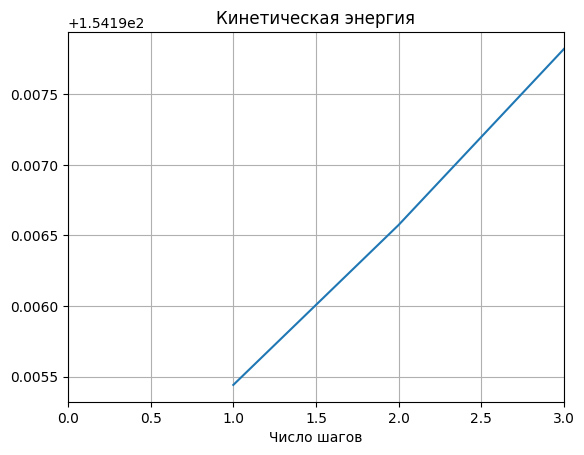

In [135]:
time = (np.arange(len(kinetic)) + 1)
fig, ax = plt.subplots()
ax.plot(time, np.array(kinetic) / E_si)
ax.grid()
ax.set_xlim((0, N_step))

#M = kinetic.max()

#ax.set_ylim((0, 60))
plt.xlabel("Число шагов")
plt.title("Потенциальная энергия")
plt.title("Кинетическая энергия")
plt.show()

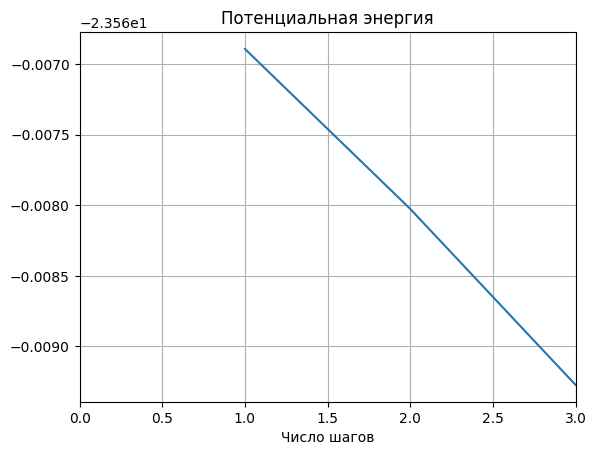

In [136]:
time = (np.arange(len(potential)) + 1)
fig, ax = plt.subplots()
ax.plot(time, np.array(potential) / E_si)
ax.grid()

#M = max(0, 2 * potential.max())
#m = min(0, 2 * potential.min())

ax.set_xlim((0, N_step))
#ax.set_ylim((-30, 0))
plt.xlabel("Число шагов")
plt.title("Потенциальная энергия")
plt.show()

In [137]:
Energy = np.array(potential) / E_si + np.array(kinetic) / E_si
M = max(0, Energy.max())
m = min(0, Energy.max())

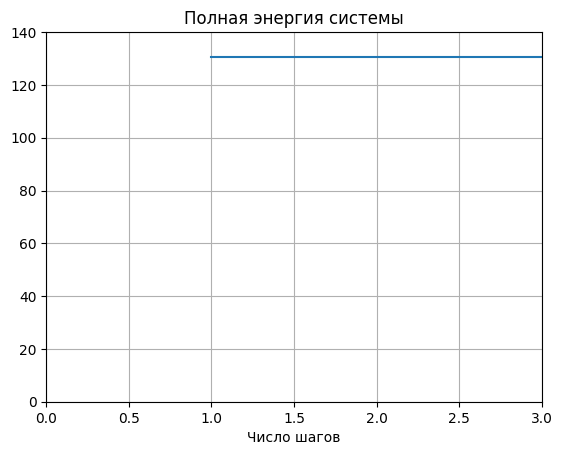

In [138]:
fig, ax = plt.subplots()
time = (np.arange(len(potential)) + 1)
ax.plot(time, Energy)
ax.set_xlim((0, N_step))
#ax.set_ylim(2 * m, 2 * M)
ax.set_ylim((0, 140))
ax.grid()
plt.xlabel("Число шагов")
plt.title("Полная энергия системы")
plt.show()

In [139]:
np.linalg.norm(velocities, axis=1).min(), np.linalg.norm(velocities, axis=1).max()

(313.67594551507403, 391.45027602880765)

In [140]:
V_x = np.array([velocities[i][0] ** 2 for i in range(n)])
V_y = np.array([velocities[i][1] ** 2 for i in range(n)])
V_z = np.array([velocities[i][2] ** 2 for i in range(n)])

In [141]:
np.sqrt((mass / (2 * np.pi * k_B * T)))

0.0013826023514143001

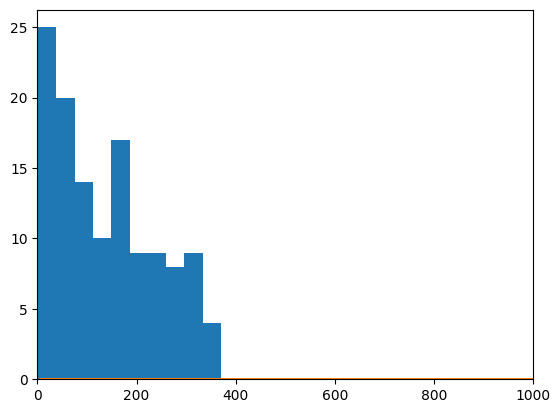

In [142]:
arr = V_y ** 0.5
fig, ax = plt.subplots()
ax.hist(arr, bins=10)   
ax.plot(V_x, np.sqrt((mass / (2 * np.pi * k_B * T))) * np.exp(- mass * V_y ** 2 / (2 * k_B * T)))
ax.set_xlim(0, 1000)
plt.show()

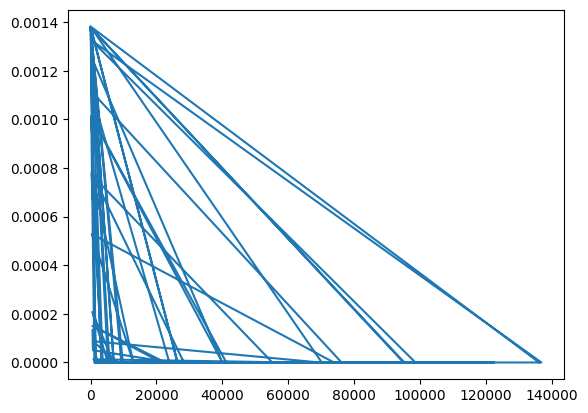

In [143]:
fig, ax = plt.subplots() 
ax.plot(V_y, np.sqrt((mass / (2 * np.pi * k_B * T))) * np.exp(- mass * V_y ** 2 / (2 * k_B * T)))
plt.show()

In [144]:
from scipy.integrate import odeint

def deriv(u):
    return 4 * np.pi * (u ** 2) *  np.sqrt((mass / (2 * np.pi * k_B * T))) * np.exp(- mass * (u ** 2) / (2 * k_B * T))

In [145]:
t = np.linspace(0, 1.5 * V_x.max(), 100)
u = odeint(deriv, 0, t)


TypeError: deriv() takes 1 positional argument but 2 were given